In [11]:
import time
import os
import cv2
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

from lib.file.TIF import *
from lib.analysis.ROI_identification import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.file.TSV import RegionExporter
from lib.analysis.align import ImageAlign
from lib.file.DAT import TracesDAT
from lib.trace import Tracer
from lib.utilities import *
from lib.analysis.laminar_dist import *

In [12]:
# Load data, for any Google Drive for desktop
data_dir = "G:/.shortcut-targets-by-id/"
dir_name = 'Choosing trajectories'
filename = 'raw_velocity_data_JJ.csv'
depth_limit = 4

# just finding the dir
for subdir, dirs, files in os.walk(data_dir):
    depth = subdir.count('/') + subdir.count('\\')
    if depth > depth_limit:  # don't care about any deeper dir
        continue
    if 'Choosing trajectories' in subdir:
        dir_name = subdir
        filename = subdir + '/' + filename
        break

In [13]:
# Fill in more of synapse_count_map from file
synaptic_column = "Synaptic"
latency_column = 'Latency_Mono_Raw'
run_Kate_numbers = True

synapse_count_map = {}
if run_Kate_numbers:
    synaptic_column = "Kate's Synaptic"
    latency_column = "Kate's Mono Latency"

filename_combined = dir_name + '/raw_velocity_data_JJ_KS_compare.csv'
df_combined = pd.read_csv(filename_combined)
df_combined = pd.DataFrame(df_combined, columns=['Date', 'Slice_Loc_Run',
                              'Stim_Layer', 'Laminar', 'ROI_Id', 'Synaptic', 'Kate\'s Synaptic',
                               'Latency_Mono_Raw', 'Kate\'s Mono Latency', 'Distance'])
print(df_combined)
for date in df_combined.Date.unique():
    cv_subset_date = df_combined[(df_combined['Date'] == date)]
    for rec_id in cv_subset_date.Slice_Loc_Run.unique():
        cv_subset_rec_id = cv_subset_date[(cv_subset_date['Slice_Loc_Run'] == rec_id)]
        for laminar_val in cv_subset_rec_id.Laminar.unique():
            cv_subset_lam = cv_subset_rec_id[(cv_subset_rec_id['Laminar'] == laminar_val)]
            for layer_val in cv_subset_lam.Stim_Layer.unique():
                plot_key = date + " " + rec_id + " " + laminar_val + " " + layer_val
                cv_subset = cv_subset_lam[(cv_subset_lam['Stim_Layer'] == layer_val)]
                if plot_key not in synapse_count_map:
                    synapse_count_map[plot_key] = {0: [], 1: [], 2:[]}
                    for idx, row in cv_subset.iterrows():
                        roi_id_0 = int(row['ROI_Id']) - 1
                        if type(row[synaptic_column]) == str:
                            
                            if "Mono" in row[synaptic_column]:
                                print(roi_id_0, 1)
                                synapse_count_map[plot_key][1].append(roi_id_0)
                            elif "Disyn" in row[synaptic_column]:
                                print(roi_id_0, 2)
                                synapse_count_map[plot_key][2].append(roi_id_0)
                            elif "Dir" in row[synaptic_column]:
                                print(roi_id_0, 0)
                                synapse_count_map[plot_key][0].append(roi_id_0)
                

            Date Slice_Loc_Run Stim_Layer Laminar  ROI_Id            Synaptic  \
0     10_02_2020      02_01_05        2_3   Inter       1  Direct Stimulation   
1     10_02_2020      02_01_05        2_3   Inter       2  Direct Stimulation   
2     10_02_2020      02_01_05        2_3   Inter       3  Direct Stimulation   
3     10_02_2020      02_01_05        2_3   Inter       4  Direct Stimulation   
4     10_02_2020      02_01_05        2_3   Inter       5  Direct Stimulation   
...          ...           ...        ...     ...     ...                 ...   
1782  09_06_2021      08_01_04        2_3   Intra      10             No_resp   
1783  09_06_2021      08_01_04        2_3   Intra      11          Disynaptic   
1784  09_06_2021      08_01_04        2_3   Intra      12          Disynaptic   
1785  09_06_2021      08_01_04        2_3   Intra      13          Disynaptic   
1786  09_06_2021      08_01_04        2_3   Intra      14          Disynaptic   

     Kate's Synaptic  Laten

#  10_02_2020 02_01_05 Inter 2_3
0-synapse Velocity: 219.6 um / ms
	P-value: 0.0026962885031612312
1-synapse Velocity: 191.97 um / ms
	P-value: 0.0026962885031612312
Num points: 14


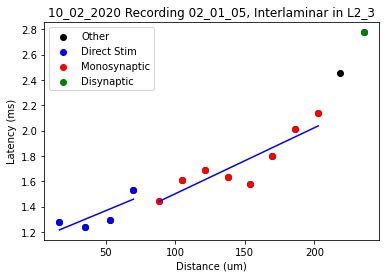

#  10_02_2020 02_01_05 Intra 2_3
0-synapse Velocity: -212.71 um / ms
	P-value: 0.022384137265179262
1-synapse Velocity: 172.43 um / ms
	P-value: 0.022384137265179262
2-synapse Velocity: -51.84 um / ms
	P-value: 0.022384137265179262
Num points: 23


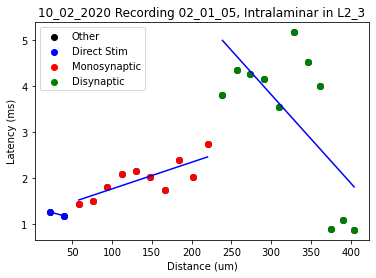

#  10_27_2020 03_01_06 Intra 4
1-synapse Velocity: -238.78 um / ms
	P-value: 0.07156349173609629
2-synapse Velocity: 181.31 um / ms
	P-value: 0.07156349173609629
Num points: 14


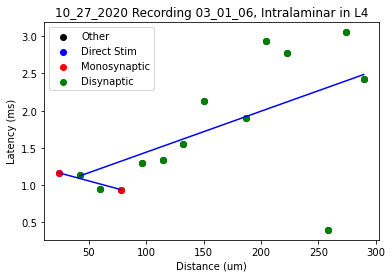

#  12_13_2020 02_01_02 Intra 4
1-synapse Velocity: 271.69 um / ms
	P-value: 0.6092746477496976
2-synapse Velocity: 210.52 um / ms
	P-value: 0.6092746477496976
Num points: 15


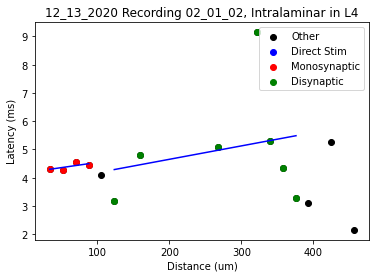

#  12_28_2020 03_01_08 Intra 2_3
1-synapse Velocity: -44.63 um / ms
	P-value: nan
Num points: 14


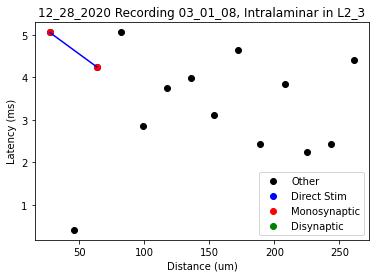

#  12_28_2020 04_01_01 Inter_L5 4
1-synapse Velocity: 53.02 um / ms
	P-value: 0.027546639445608867
Num points: 9


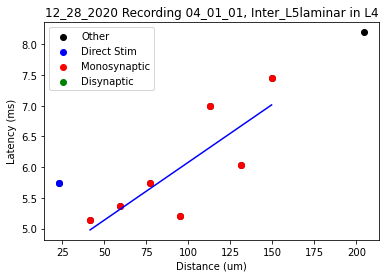

#  12_28_2020 06_01_01 Inter_L23 4
2-synapse Velocity: -110.13 um / ms
	P-value: 0.531905949816563
Num points: 10


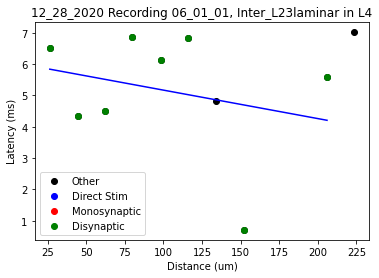

#  12_28_2020 08_01_04 Inter_L23 4
1-synapse Velocity: 179.97 um / ms
	P-value: 0.6106960603765783
2-synapse Velocity: 484.58 um / ms
	P-value: 0.6106960603765783
Num points: 17


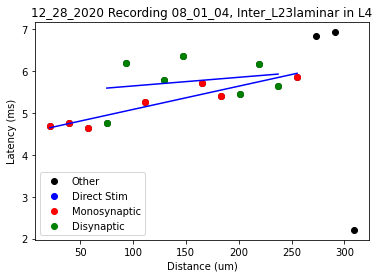

#  12_28_2020 10_01_01 Inter_L23 4
1-synapse Velocity: -156.45 um / ms
	P-value: 0.22488014868409958
2-synapse Velocity: -73.15 um / ms
	P-value: 0.22488014868409958
Num points: 12


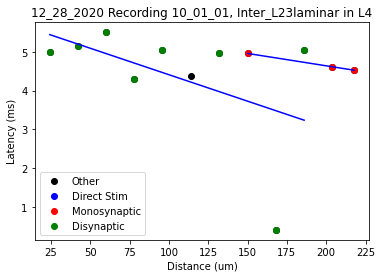

#  12_28_2020 11_01_06 Inter_L23 4
0-synapse Velocity: -38.16 um / ms
	P-value: 0.00469812899466673
1-synapse Velocity: -123.89 um / ms
	P-value: 0.00469812899466673
2-synapse Velocity: 40.48 um / ms
	P-value: 0.00469812899466673
Num points: 10


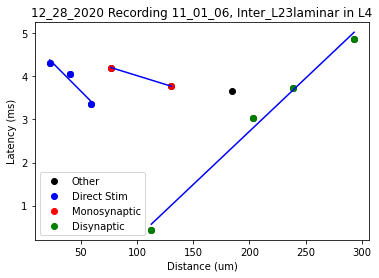

#  12_29_2020 04_01_01 Inter_L23 4
1-synapse Velocity: 745.01 um / ms
	P-value: 0.5658310602872514
Num points: 16


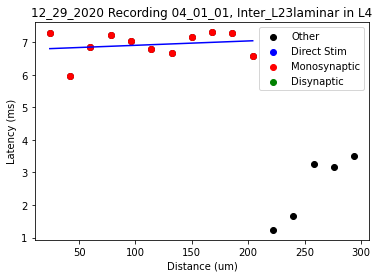

#  12_29_2020 06_01_01 Inter_L23 4
1-synapse Velocity: 164.92 um / ms
	P-value: 0.02170463828271385
Num points: 17


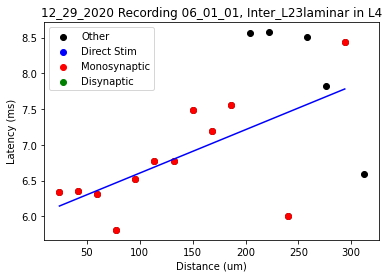

#  12_29_2020 07_01_03 Intra 4
0-synapse Velocity: 45.79 um / ms
	P-value: 0.03198021701720477
1-synapse Velocity: 73.98 um / ms
	P-value: 0.03198021701720477
Num points: 16


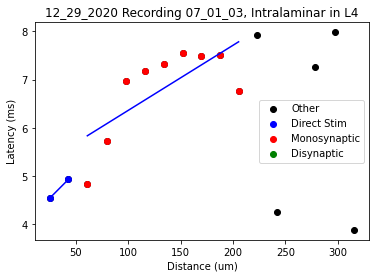

#  12_29_2020 09_01_02 Inter_L23 4
1-synapse Velocity: 167.2 um / ms
	P-value: 0.0018013930489323754
Num points: 11


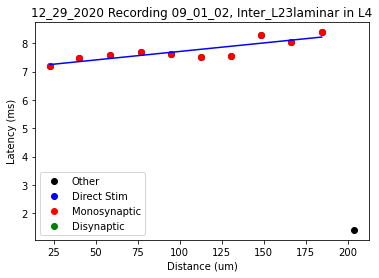

#  01_11_2021 09_01_01 Inter 2_3
2-synapse Velocity: -181.47 um / ms
	P-value: 0.22460025751575372
Num points: 10


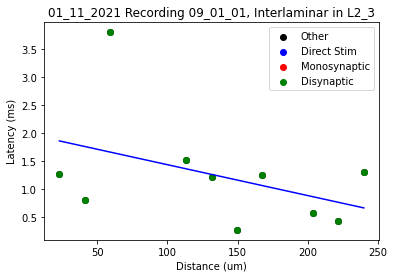

#  01_18_2021 04_01_02 Inter 2_3
0-synapse Velocity: 115.3 um / ms
	P-value: 0.0036571407972822907
2-synapse Velocity: -48.79 um / ms
	P-value: 0.0036571407972822907
Num points: 20


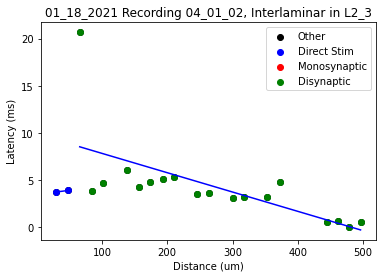

#  01_18_2021 05_01_03 Inter 2_3
2-synapse Velocity: -622.78 um / ms
	P-value: 0.5828576823139764
Num points: 15


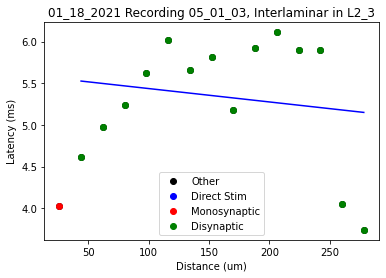

#  01_18_2021 07_01_02 Inter 2_3
0-synapse Velocity: 112.76 um / ms
	P-value: 0.49614629929445475
2-synapse Velocity: -472.5 um / ms
	P-value: 0.49614629929445475
Num points: 20


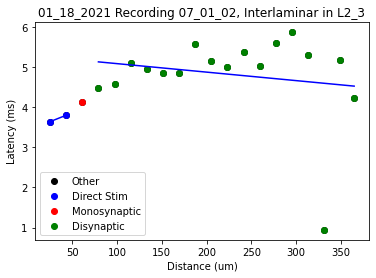

#  01_19_2021 05_01_01 Inter 2_3
2-synapse Velocity: 41.12 um / ms
	P-value: 0.4905928814843583
Num points: 14


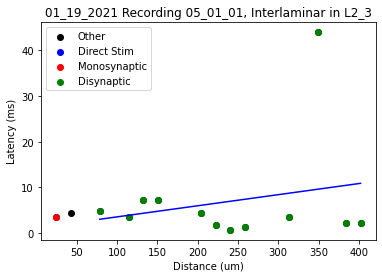

#  03_02_2021 03_01_02 Inter 5
1-synapse Velocity: 105.03 um / ms
	P-value: 0.01298812711891672
2-synapse Velocity: 200.23 um / ms
	P-value: 0.01298812711891672
Num points: 24


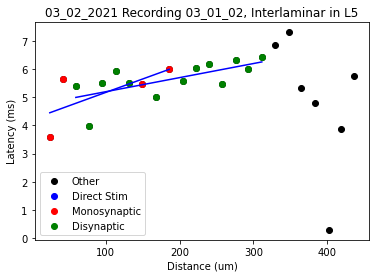

#  03_02_2021 05_01_02 Inter 5
1-synapse Velocity: 139.01 um / ms
	P-value: nan
2-synapse Velocity: 35.76 um / ms
	P-value: nan
Num points: 23


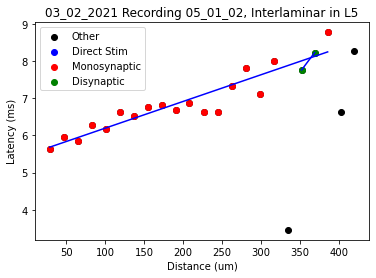

#  03_02_2021 07_01_03 Inter 5
1-synapse Velocity: 259.59 um / ms
	P-value: 0.9808186960666083
2-synapse Velocity: 8422.58 um / ms
	P-value: 0.9808186960666083
Num points: 21


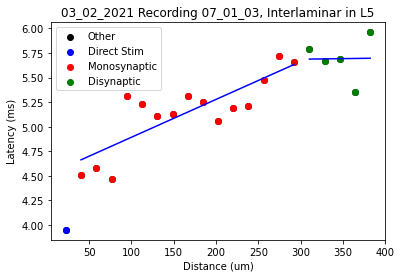

#  03_02_2021 08_01_01 Intra 5
1-synapse Velocity: 84.33 um / ms
	P-value: 0.7862734094181858
2-synapse Velocity: -244.13 um / ms
	P-value: 0.7862734094181858
Num points: 13


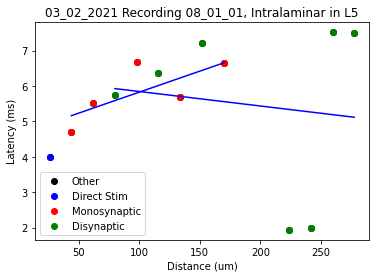

#  03_02_2021 08_01_01 Inter 5
1-synapse Velocity: 90.62 um / ms
	P-value: 0.23825450145545216
2-synapse Velocity: -192.35 um / ms
	P-value: 0.23825450145545216
Num points: 20


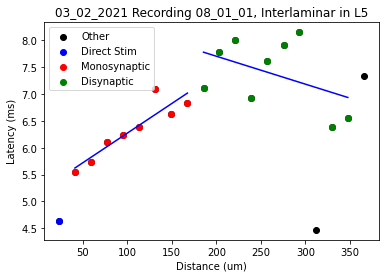

#  03_09_2021 03_01_02 Inter 5
1-synapse Velocity: 288.25 um / ms
	P-value: 0.0014727913747596272
2-synapse Velocity: 297.14 um / ms
	P-value: 0.0014727913747596272
Num points: 21


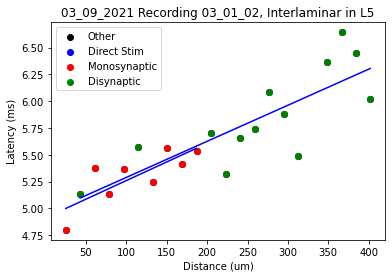

#  03_09_2021 05_01_02 Inter 5
1-synapse Velocity: 323.48 um / ms
	P-value: 0.0008381944239942808
Num points: 18


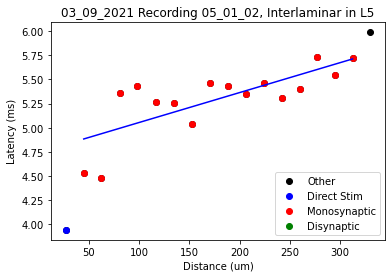

#  03_23_2021 05_01_02 Inter 5
1-synapse Velocity: 195.69 um / ms
	P-value: 0.005436757025821372
Num points: 14


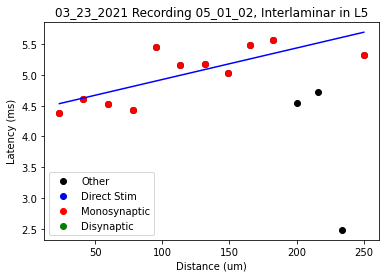

#  03_23_2021 05_01_02 Intra 5
1-synapse Velocity: 199.45 um / ms
	P-value: 0.08540401891793646
Num points: 18


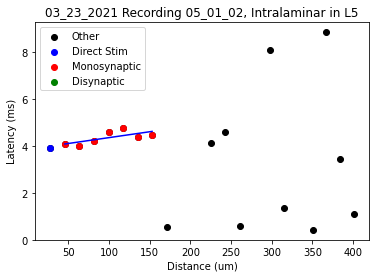

#  03_23_2021 06_01_01 Inter 5
1-synapse Velocity: 406.01 um / ms
	P-value: 0.023372762459130034
Num points: 17


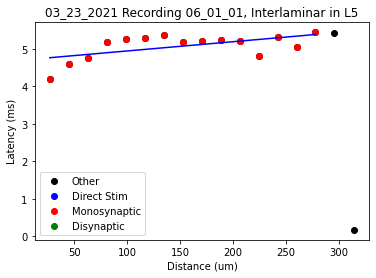

#  03_23_2021 07_01_01 Inter 5
1-synapse Velocity: 191.92 um / ms
	P-value: 0.2724938953718458
2-synapse Velocity: 33.5 um / ms
	P-value: 0.2724938953718458
Num points: 21


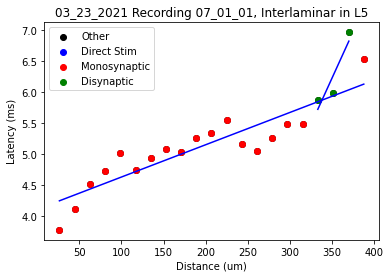

#  04_13_2021 03_01_02 Inter 5
1-synapse Velocity: 218.63 um / ms
	P-value: 0.0001827651673603962
Num points: 16


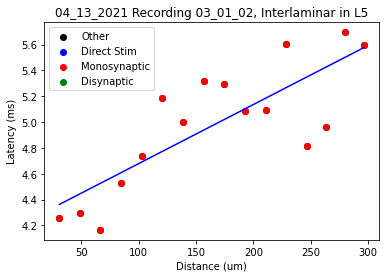

#  04_13_2021 03_01_02 Intra 5
1-synapse Velocity: 68.99 um / ms
	P-value: 0.0053096913589324455
2-synapse Velocity: 86.14 um / ms
	P-value: 0.0053096913589324455
Num points: 17


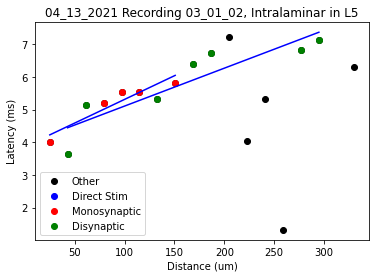

#  04_13_2021 04_01_02 Inter 2_3
1-synapse Velocity: 529.35 um / ms
	P-value: 0.07793536129044877
2-synapse Velocity: -72.72 um / ms
	P-value: 0.07793536129044877
Num points: 12


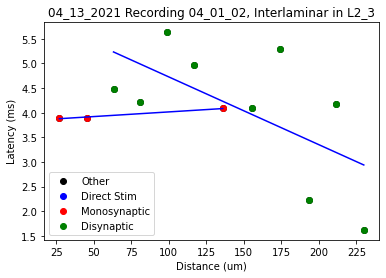

#  04_13_2021 05_01_01 Intra 2_3
0-synapse Velocity: 2643.48 um / ms
	P-value: 2.459109218868297e-08
1-synapse Velocity: 175.5 um / ms
	P-value: 2.459109218868297e-08
2-synapse Velocity: 106.39 um / ms
	P-value: 2.459109218868297e-08
Num points: 18


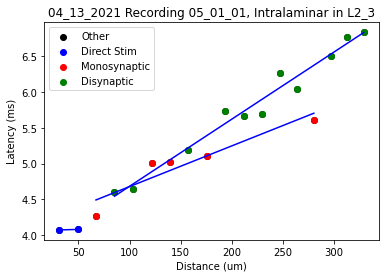

#  04_13_2021 05_01_01 Inter 2_3
1-synapse Velocity: 412.65 um / ms
	P-value: 0.00018168375216589885
2-synapse Velocity: 144.53 um / ms
	P-value: 0.00018168375216589885
Num points: 16


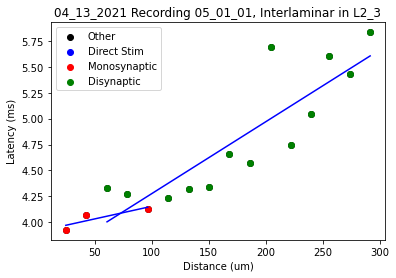

#  04_13_2021 06_01_01 Inter 2_3
0-synapse Velocity: 189.98 um / ms
	P-value: 5.574001651789143e-05
2-synapse Velocity: 186.63 um / ms
	P-value: 5.574001651789143e-05
Num points: 22


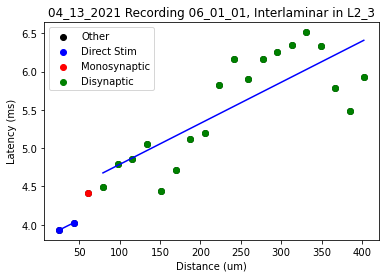

#  04_13_2021 07_01_02 Inter_L23 4
1-synapse Velocity: 456.82 um / ms
	P-value: 0.2519568070222955
2-synapse Velocity: -103.24 um / ms
	P-value: 0.2519568070222955
Num points: 21


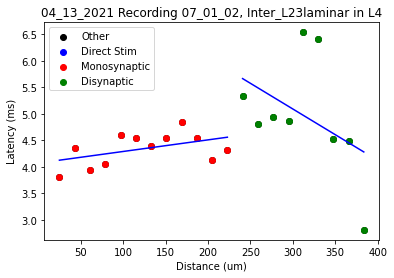

#  04_13_2021 07_01_02 Intra 4
0-synapse Velocity: 3973.33 um / ms
	P-value: 0.0025083123719746394
1-synapse Velocity: 239.29 um / ms
	P-value: 0.0025083123719746394
Num points: 14


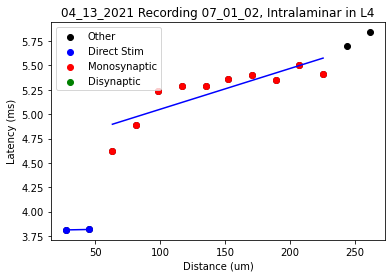

#  04_13_2021 08_01_01 Inter 2_3
0-synapse Velocity: 90.71 um / ms
	P-value: 0.0420524055003507
2-synapse Velocity: 128.17 um / ms
	P-value: 0.0420524055003507
Num points: 12


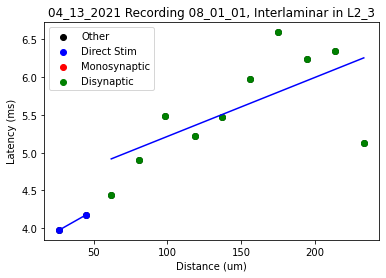

#  05_25_2021 01_01_04 Intra 2_3
1-synapse Velocity: 676.04 um / ms
	P-value: 0.06177554292311581
Num points: 18


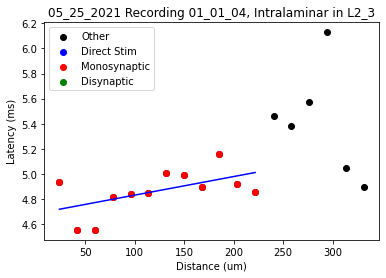

#  05_25_2021 02_01_03 Inter 2_3
1-synapse Velocity: 259.62 um / ms
	P-value: 0.9315183358285835
2-synapse Velocity: -1626.3 um / ms
	P-value: 0.9315183358285835
Num points: 17


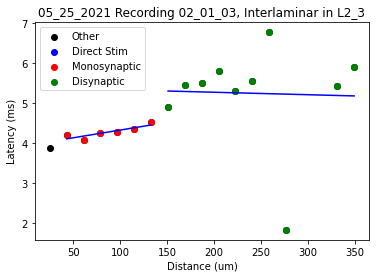

#  05_25_2021 02_01_03 Intra 2_3
1-synapse Velocity: 71.6 um / ms
	P-value: 0.052106730856649096
2-synapse Velocity: 21.85 um / ms
	P-value: 0.052106730856649096
Num points: 12


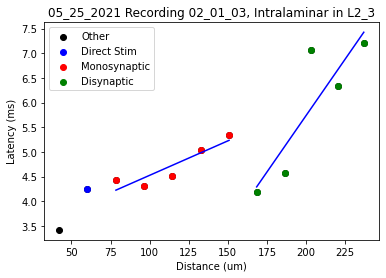

#  05_25_2021 03_01_05 Inter 2_3
1-synapse Velocity: -1479.5 um / ms
	P-value: 0.011559105701426266
2-synapse Velocity: -118.04 um / ms
	P-value: 0.011559105701426266
Num points: 17


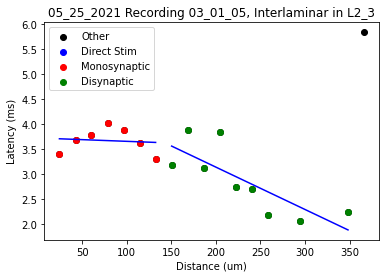

#  05_25_2021 04_01_03 Inter 2_3
2-synapse Velocity: 201.51 um / ms
	P-value: 0.020511992829608076
Num points: 15


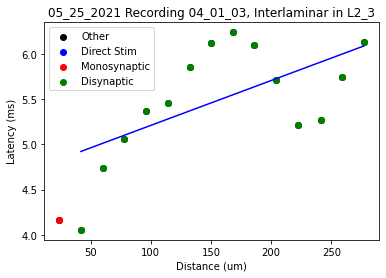

#  05_25_2021 05_01_04 Inter 2_3
0-synapse Velocity: 72.47 um / ms
	P-value: 0.2322431927119308
1-synapse Velocity: -4780.75 um / ms
	P-value: 0.2322431927119308
2-synapse Velocity: 258.02 um / ms
	P-value: 0.2322431927119308
Num points: 12


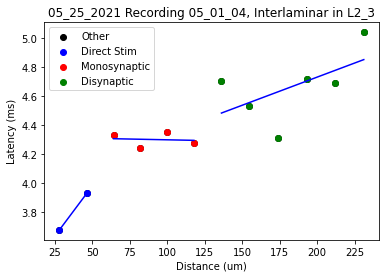

#  05_25_2021 07_01_03 Intra 4
0-synapse Velocity: 194.6 um / ms
	P-value: 0.013324066544295592
2-synapse Velocity: 109.0 um / ms
	P-value: 0.013324066544295592
Num points: 15


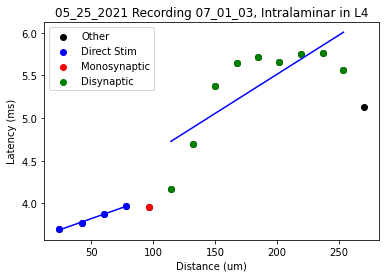

#  05_25_2021 08_01_04 Inter_L23 4
1-synapse Velocity: 320.42 um / ms
	P-value: 0.5673954345661048
2-synapse Velocity: 977.53 um / ms
	P-value: 0.5673954345661048
Num points: 22


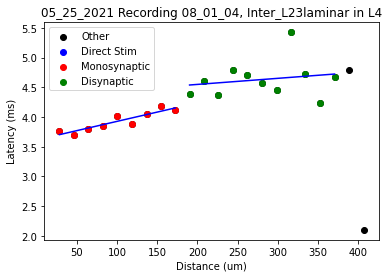

#  05_25_2021 08_01_04 Intra 4
1-synapse Velocity: 182.28 um / ms
	P-value: 6.147107824382832e-05
Num points: 12


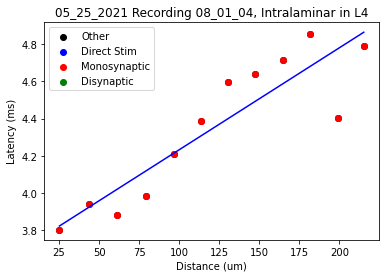

#  05_25_2021 09_01_04 Inter 2_3
1-synapse Velocity: 230.71 um / ms
	P-value: 0.004628057742576343
2-synapse Velocity: 175.21 um / ms
	P-value: 0.004628057742576343
Num points: 16


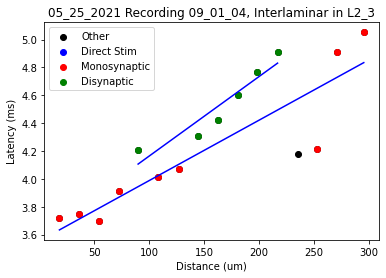

#  05_25_2021 09_01_04 Intra 2_3
1-synapse Velocity: 139.17 um / ms
	P-value: nan
2-synapse Velocity: 290.54 um / ms
	P-value: nan
Num points: 17


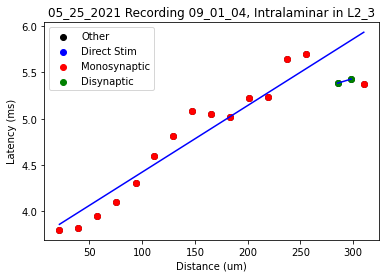

#  05_26_2021 02_01_04 Inter 2_3
1-synapse Velocity: 179.12 um / ms
	P-value: 0.5815890398384093
2-synapse Velocity: -246.87 um / ms
	P-value: 0.5815890398384093
Num points: 17


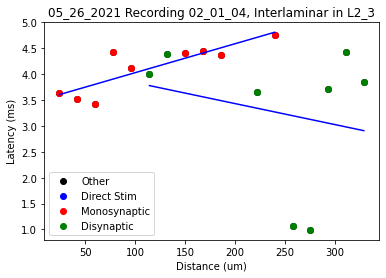

#  05_26_2021 04_01_05 Inter 2_3
1-synapse Velocity: 429.95 um / ms
	P-value: 0.6644498880315726
2-synapse Velocity: -202.98 um / ms
	P-value: 0.6644498880315726
Num points: 16


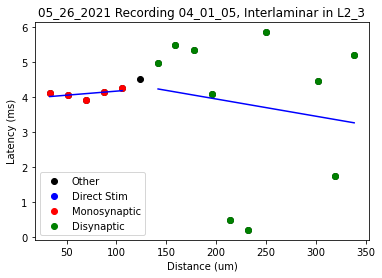

#  05_26_2021 04_01_05 Intra 2_3
1-synapse Velocity: 112.13 um / ms
	P-value: 0.8135678432262667
2-synapse Velocity: -76.99 um / ms
	P-value: 0.8135678432262667
Num points: 12


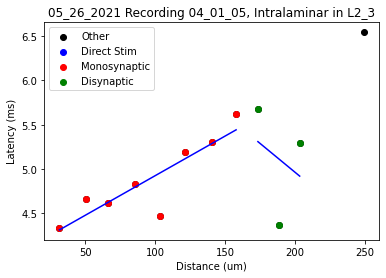

#  05_26_2021 05_01_03 Inter 2_3
1-synapse Velocity: -464.96 um / ms
	P-value: 0.5489221438653011
2-synapse Velocity: 44.09 um / ms
	P-value: 0.5489221438653011
Num points: 17


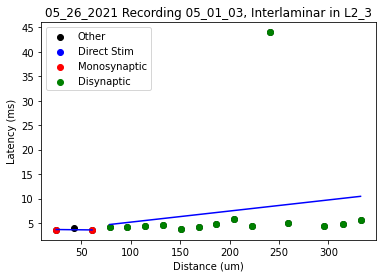

#  05_26_2021 05_01_03 Intra 2_3
0-synapse Velocity: 74.91 um / ms
	P-value: 0.4884308885999137
1-synapse Velocity: 208.52 um / ms
	P-value: 0.4884308885999137
2-synapse Velocity: -88.37 um / ms
	P-value: 0.4884308885999137
Num points: 14


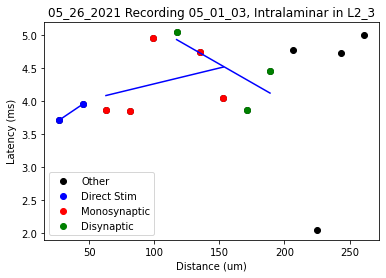

#  05_26_2021 07_01_03 Inter_L5 4
1-synapse Velocity: 56.44 um / ms
	P-value: 0.08378556574139766
2-synapse Velocity: 179.44 um / ms
	P-value: 0.08378556574139766
Num points: 17


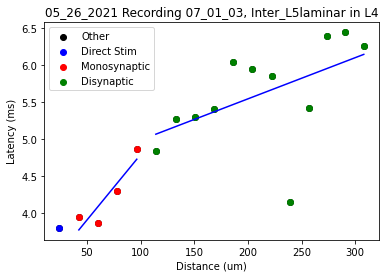

#  05_26_2021 07_01_03 Intra 4
0-synapse Velocity: -395.63 um / ms
	P-value: nan
1-synapse Velocity: 97.58 um / ms
	P-value: nan
2-synapse Velocity: -25.14 um / ms
	P-value: nan
Num points: 19


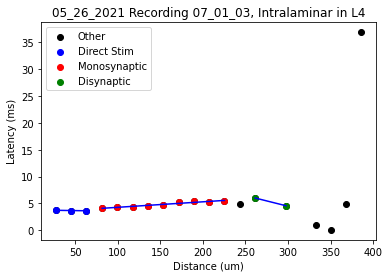

#  05_31_2021 05_01_04 Inter 5
1-synapse Velocity: 323.13 um / ms
	P-value: 0.4719333455480178
2-synapse Velocity: -486.15 um / ms
	P-value: 0.4719333455480178
Num points: 28


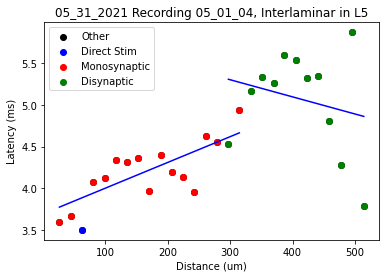

#  05_31_2021 06_01_05 Inter 2_3
1-synapse Velocity: 233.28 um / ms
	P-value: 0.982477671253976
2-synapse Velocity: -19855.29 um / ms
	P-value: 0.982477671253976
Num points: 19


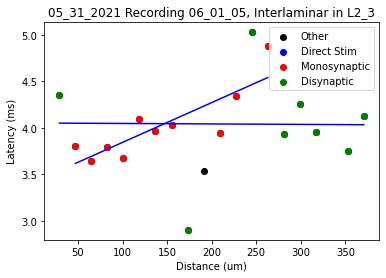

#  05_31_2021 06_01_05 Intra 2_3
1-synapse Velocity: 680.91 um / ms
	P-value: 0.8456476169510341
2-synapse Velocity: -121.15 um / ms
	P-value: 0.8456476169510341
Num points: 16


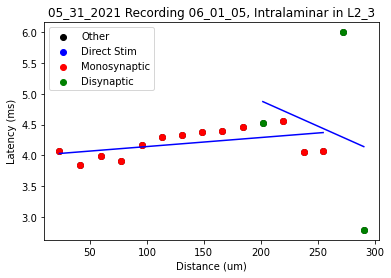

#  05_31_2021 07_01_05 Inter 2_3
0-synapse Velocity: 221.63 um / ms
	P-value: 0.08457719489074085
2-synapse Velocity: -60.09 um / ms
	P-value: 0.08457719489074085
Num points: 18


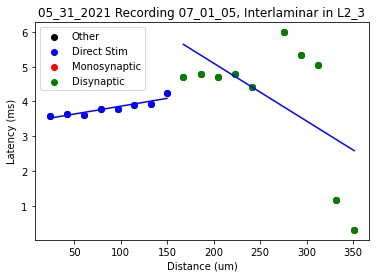

#  05_31_2021 07_01_05 Intra 2_3
0-synapse Velocity: -364.71 um / ms
	P-value: 0.00308170074237473
1-synapse Velocity: 325.25 um / ms
	P-value: 0.00308170074237473
2-synapse Velocity: -35.4 um / ms
	P-value: 0.00308170074237473
Num points: 17


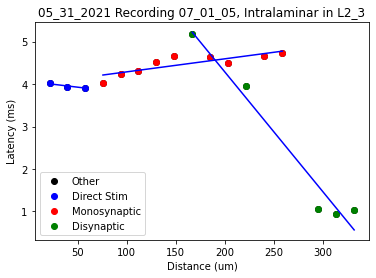

#  05_31_2021 09_01_05 Inter 2_3
1-synapse Velocity: 757.17 um / ms
	P-value: 0.0007096054132330444
Num points: 16


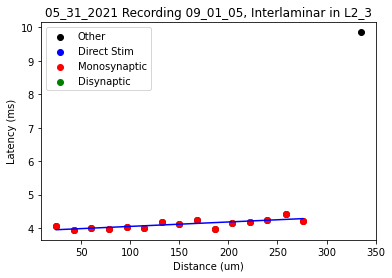

#  05_31_2021 10_01_05 Inter 2_3
1-synapse Velocity: 210.8 um / ms
	P-value: 0.5470923142791422
2-synapse Velocity: 690.82 um / ms
	P-value: 0.5470923142791422
Num points: 21


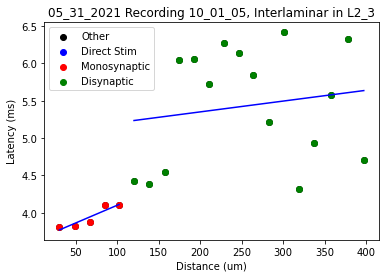

#  06_28_2021 03_01_02 Inter 5
0-synapse Velocity: 201.33 um / ms
	P-value: 9.172826755569265e-09
1-synapse Velocity: 279.21 um / ms
	P-value: 9.172826755569265e-09
Num points: 26


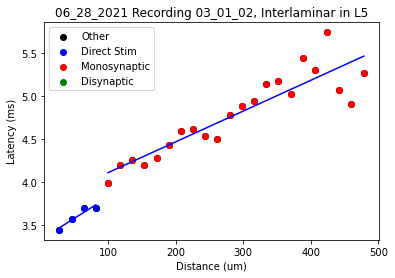

#  06_28_2021 04_01_02 Inter 5
0-synapse Velocity: 237.82 um / ms
	P-value: 0.05087556881342115
1-synapse Velocity: 280.43 um / ms
	P-value: 0.05087556881342115
2-synapse Velocity: 203.5 um / ms
	P-value: 0.05087556881342115
Num points: 27


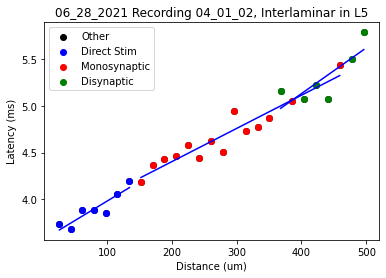

#  06_28_2021 05_01_02 Inter 5
0-synapse Velocity: 307.17 um / ms
	P-value: 1.0353423326830691e-08
1-synapse Velocity: 401.93 um / ms
	P-value: 1.0353423326830691e-08
Num points: 24


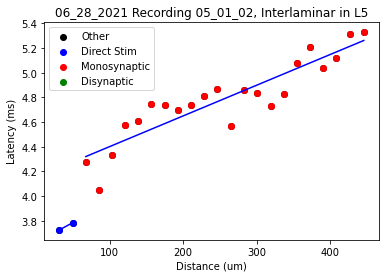

#  06_28_2021 06_01_01 Inter 5
0-synapse Velocity: 346.54 um / ms
	P-value: 1.8435605824008e-10
1-synapse Velocity: 233.1 um / ms
	P-value: 1.8435605824008e-10
Num points: 27


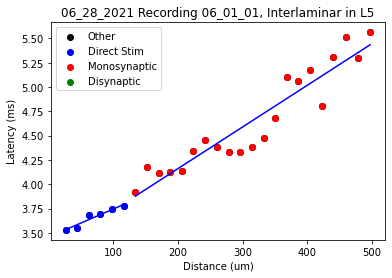

#  06_29_2021 02_01_02 Inter 5
1-synapse Velocity: 213.35 um / ms
	P-value: 0.2660692122794992
2-synapse Velocity: 1099.32 um / ms
	P-value: 0.2660692122794992
Num points: 24


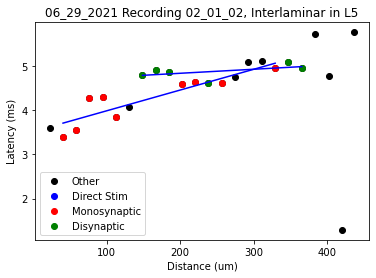

#  06_29_2021 02_01_02 Intra 5
1-synapse Velocity: 155.18 um / ms
	P-value: nan
2-synapse Velocity: 171.39 um / ms
	P-value: nan
Num points: 15


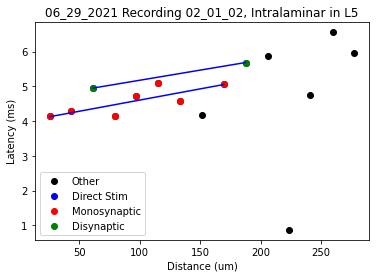

#  06_29_2021 04_01_02 Inter 5
1-synapse Velocity: -165.11 um / ms
	P-value: 0.09971433796138306
Num points: 20


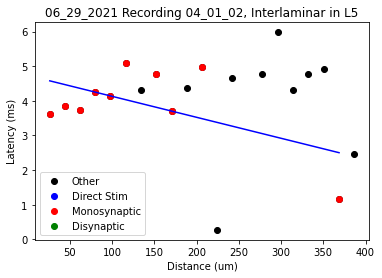

#  06_29_2021 04_01_02 Intra 5
1-synapse Velocity: 96.7 um / ms
	P-value: nan
2-synapse Velocity: 106.68 um / ms
	P-value: nan
Num points: 17


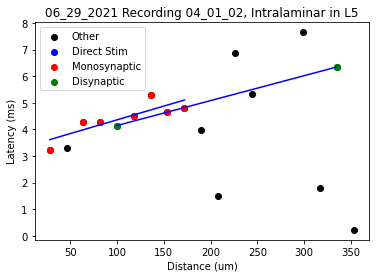

#  06_29_2021 05_01_01 Inter 5
1-synapse Velocity: 299.38 um / ms
	P-value: 4.5380838563818075e-11
Num points: 21


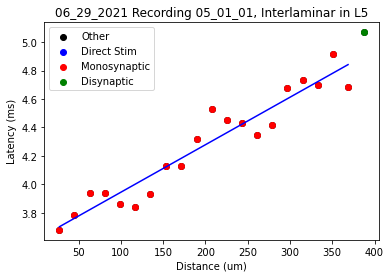

#  06_29_2021 05_01_01 Intra 5
1-synapse Velocity: 76.22 um / ms
	P-value: 0.02989743333748259
2-synapse Velocity: 220.53 um / ms
	P-value: 0.02989743333748259
Num points: 15


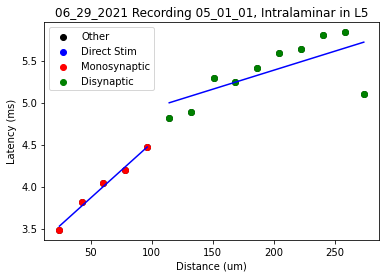

#  06_29_2021 07_01_02 Inter 5
1-synapse Velocity: 382.26 um / ms
	P-value: 1.7877702074645388e-07
Num points: 23


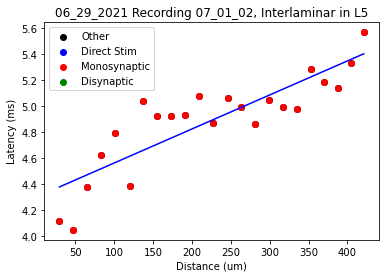

#  08_06_2021 02_01_02 Inter_L5 4
1-synapse Velocity: -358.43 um / ms
	P-value: 0.23981636002569368
2-synapse Velocity: -222.54 um / ms
	P-value: 0.23981636002569368
Num points: 24


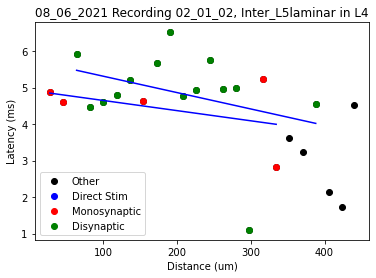

#  08_06_2021 02_01_02 Intra 4
1-synapse Velocity: 156.06 um / ms
	P-value: nan
2-synapse Velocity: 25.19 um / ms
	P-value: nan
Num points: 11


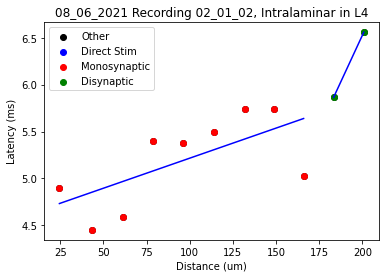

#  08_06_2021 04_01_01 Inter 2_3
1-synapse Velocity: 248.41 um / ms
	P-value: 0.07698232788040804
2-synapse Velocity: 191.58 um / ms
	P-value: 0.07698232788040804
Num points: 18


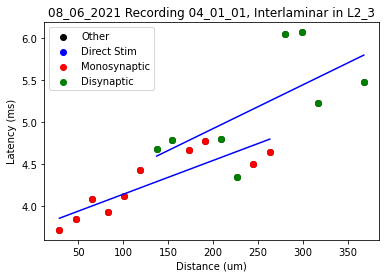

#  08_06_2021 04_01_01 Intra 2_3
1-synapse Velocity: 148.97 um / ms
	P-value: 0.8051104993932193
2-synapse Velocity: 315.76 um / ms
	P-value: 0.8051104993932193
Num points: 16


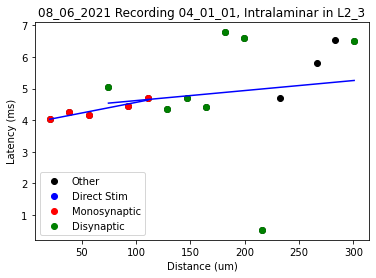

#  08_06_2021 05_01_03 Inter 2_3
1-synapse Velocity: 259.97 um / ms
	P-value: 0.16515708042953295
2-synapse Velocity: -108.36 um / ms
	P-value: 0.16515708042953295
Num points: 18


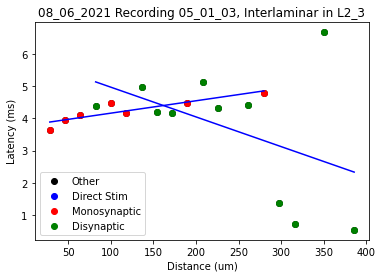

#  08_06_2021 05_01_03 Intra 2_3
1-synapse Velocity: 100.48 um / ms
	P-value: 0.7458198876518498
2-synapse Velocity: 34.73 um / ms
	P-value: 0.7458198876518498
Num points: 17


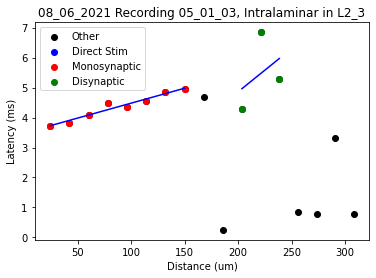

#  08_06_2021 07_01_03 Inter_L5 4
1-synapse Velocity: 249.66 um / ms
	P-value: 0.6875886971789024
2-synapse Velocity: -484.87 um / ms
	P-value: 0.6875886971789024
Num points: 22


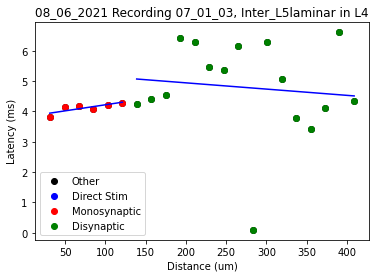

#  08_06_2021 07_01_03 Intra 4
1-synapse Velocity: 118.56 um / ms
	P-value: 0.045957723346611065
2-synapse Velocity: 92.03 um / ms
	P-value: 0.045957723346611065
Num points: 13


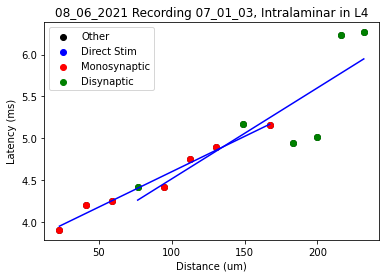

#  08_06_2021 08_01_03 Intra 2_3
1-synapse Velocity: 231.75 um / ms
	P-value: 0.11414323274217382
2-synapse Velocity: -298.7 um / ms
	P-value: 0.11414323274217382
Num points: 18


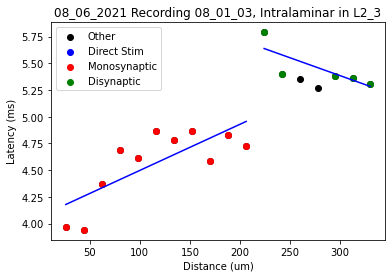

#  08_06_2021 08_01_03 Inter 2_3
1-synapse Velocity: 278.82 um / ms
	P-value: 0.49688247602492863
2-synapse Velocity: -284.78 um / ms
	P-value: 0.49688247602492863
Num points: 19


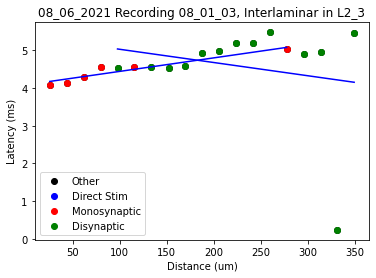

#  08_09_2021 05_01_06 Inter_L5 4
0-synapse Velocity: 853.85 um / ms
	P-value: 0.3167307068028713
1-synapse Velocity: 133.78 um / ms
	P-value: 0.3167307068028713
2-synapse Velocity: -201.1 um / ms
	P-value: 0.3167307068028713
Num points: 21


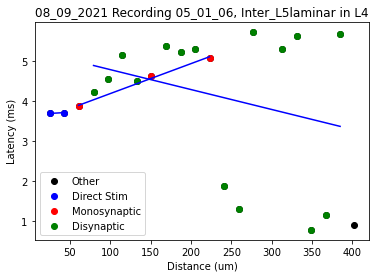

#  08_09_2021 06_01_04 Inter 2_3
1-synapse Velocity: -507.84 um / ms
	P-value: 0.6815854129260369
2-synapse Velocity: 1405.71 um / ms
	P-value: 0.6815854129260369
Num points: 19


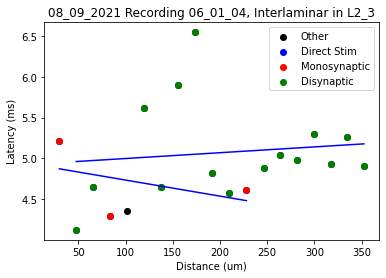

#  08_31_2021 03_01_02 Inter 2_3
1-synapse Velocity: 292.79 um / ms
	P-value: 0.029816006640850296
2-synapse Velocity: -95.18 um / ms
	P-value: 0.029816006640850296
Num points: 22


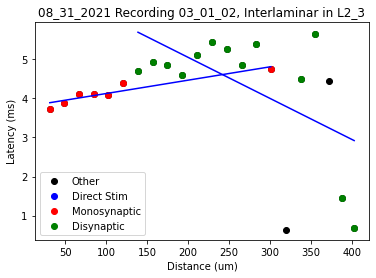

#  09_06_2021 02_01_06 Inter 2_3
1-synapse Velocity: 130.72 um / ms
	P-value: 0.17875310746081277
2-synapse Velocity: 167.57 um / ms
	P-value: 0.17875310746081277
Num points: 22


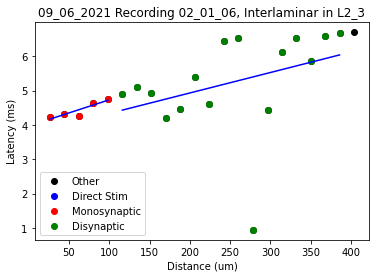

#  09_06_2021 03_01_04 Inter 2_3
1-synapse Velocity: 109.41 um / ms
	P-value: 0.4982286735501812
2-synapse Velocity: -69.85 um / ms
	P-value: 0.4982286735501812
Num points: 15


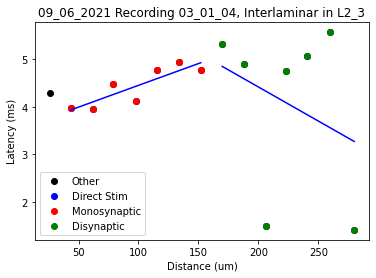

#  09_06_2021 04_01_04 Inter 2_3
1-synapse Velocity: 189.55 um / ms
	P-value: 0.8224996330071392
2-synapse Velocity: -847.67 um / ms
	P-value: 0.8224996330071392
Num points: 18


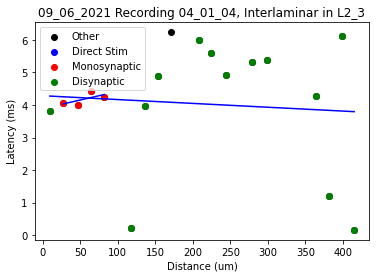

#  09_06_2021 04_01_04 Intra 2_3
1-synapse Velocity: 179.99 um / ms
	P-value: nan
2-synapse Velocity: -88.01 um / ms
	P-value: nan
Num points: 14


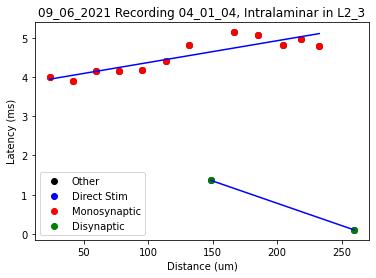

#  09_06_2021 07_01_04 Inter 2_3
1-synapse Velocity: 456.29 um / ms
	P-value: 0.5489051889301559
2-synapse Velocity: -134.24 um / ms
	P-value: 0.5489051889301559
Num points: 25


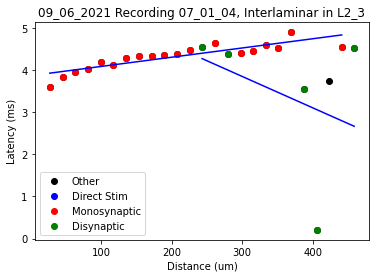

#  09_06_2021 07_01_04 Intra 2_3
1-synapse Velocity: 235.96 um / ms
	P-value: 5.025611817464911e-06
Num points: 13


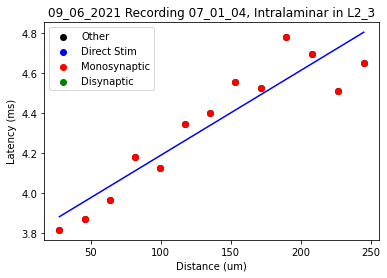

#  09_06_2021 08_01_04 Inter 2_3
1-synapse Velocity: 289.22 um / ms
	P-value: 0.6479158226715089
2-synapse Velocity: -355.81 um / ms
	P-value: 0.6479158226715089
Num points: 21


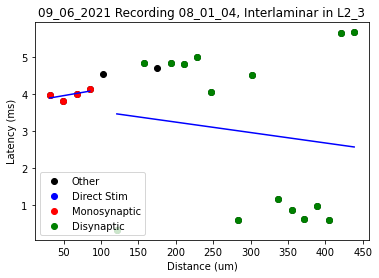

#  09_06_2021 08_01_04 Intra 2_3
1-synapse Velocity: 168.96 um / ms
	P-value: 0.8663343484976193
2-synapse Velocity: -73.62 um / ms
	P-value: 0.8663343484976193
Num points: 14


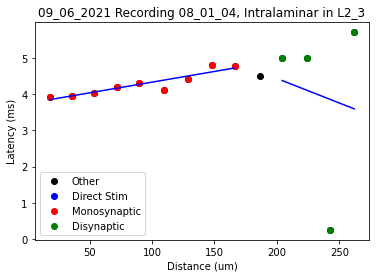

total_points: 1674
Unplotted plot keys: []


In [14]:
# load original CSV
        
#df = pd.read_csv(filename)
#df = pd.DataFrame(df, columns=['Date', 'Age_Days', 'Sex', 'Tx', 'Slice_Loc_Run',
#                              'Trial_x_Time', 'Stim_Intensity', 'Cx', 'n_Pulses',
#                              'Stim_Layer', 'Laminar', 'ROI_Id', 'SNR', 
#                               'Latency_Mono_Raw', 'Distance'])

df = df_combined

df['Latency_Calc'] = df[latency_column] - 46.0  # 46 ms is stim time
df.drop(df[df['Latency_Calc'] <= 0].index, inplace=True)  # negative values are non-physical

# 6 um per pixel on new rig (see https://github.com/john-judge/TSM-to-ZDA/issues/12)
df['Distance'] *= 6.0

# targets to plot
laminar_val_target = "Inter"
layer_val_target = "5"
plot_all = True  # overrides above 2 lines
total_points = 0
unplotted_plot_keys = []

velocity_measurements = {}
colors = ['b', 'r', 'g']
# for each recording/laminar/direction measurement, plot latency vs distance
for date in df.Date.unique():
    cv_subset_date = df[(df['Date'] == date)]
    for rec_id in cv_subset_date.Slice_Loc_Run.unique():
        cv_subset_rec_id = cv_subset_date[(cv_subset_date['Slice_Loc_Run'] == rec_id)]
        for laminar_val in cv_subset_rec_id.Laminar.unique():
            cv_subset_lam = cv_subset_rec_id[(cv_subset_rec_id['Laminar'] == laminar_val)]
            for layer_val in cv_subset_lam.Stim_Layer.unique():
                plot_key = date + " " + rec_id + " " + laminar_val + " " + layer_val
                if plot_all or (laminar_val_target == laminar_val and layer_val_target == layer_val):
                    cv_subset = cv_subset_lam[(cv_subset_lam['Stim_Layer'] == layer_val)]
                    plt.clf()
                    plt.scatter(cv_subset['Distance'], 
                                cv_subset['Latency_Calc'],
                                c='black')
                    print("# ", plot_key)
                    if plot_key in synapse_count_map:

                        # analyze and plot each synapse-count group separately
                        reg_lines = []
                        for i_synap in [0, 1, 2]:
                            ind_list = synapse_count_map[plot_key][i_synap]
                            for k in range(len(ind_list)-1, -1, -1):
                                if ind_list[k] > len(cv_subset['Distance'])-1:
                                    del ind_list[k]
                            try:
                                syn_cv_subset = cv_subset.iloc[ind_list]
                            except Exception as e:
                                print(ind_list, e)
                            dist = np.array(syn_cv_subset['Distance']).reshape(-1, 1)
                            latency = np.array(syn_cv_subset['Latency_Calc']).reshape(-1, 1)
                            plt.scatter(dist, latency, c=colors[i_synap])

                            if dist.size > 1:
                                regr = linear_model.LinearRegression()
                                regr.fit(dist, latency)
                                params = np.append(regr.intercept_, regr.coef_)
                                y_pred = regr.predict(dist)
                                velocity = round(1 / regr.coef_[0][0], 5)
                                reg_lines.append([dist, y_pred, velocity, i_synap])
                                
                                # statistical significance analysis
                                #define predictor and response variables
                                y = syn_cv_subset['Latency_Calc']
                                x = syn_cv_subset['Distance']

                                #add constant to predictor variables
                                x = sm.add_constant(x)

                                #fit linear regression model
                                model = sm.OLS(y, x).fit()

                                pvalue = model.pvalues.loc['Distance']
                                # print(model.summary())

                                is_significant_correlation = (pvalue < 0.05)
                                
                                if is_significant_correlation:
                                    vel_key = laminar_val + " " + layer_val
                                    if vel_key not in velocity_measurements:
                                        velocity_measurements[vel_key] = {}
                                    if i_synap not in velocity_measurements[vel_key]:
                                        velocity_measurements[vel_key][i_synap] = []
                                    velocity_measurements[vel_key][i_synap].append(velocity)

                        plt.legend(["Other","Direct Stim", "Monosynaptic", "Disynaptic"])
                        for rl in reg_lines:
                            dist, y_pred, velocity, i_synap = rl
                            plt.plot(dist, y_pred, c='b')
                            print(str(i_synap) + "-synapse Velocity:", round(velocity, 2), "um / ms")
                            print("\tP-value:", pvalue)
                    else:
                        unplotted_plot_keys.append(plot_key)

                    plt.title(date + " Recording " + rec_id + ", " + laminar_val + "laminar in L" + layer_val)
                    plt.xlabel('Distance (um)')
                    plt.ylabel('Latency (ms)')
                    total_points += len(cv_subset['Distance'])
                    print("Num points:", len(cv_subset['Distance']))
                    plt.show()
                    
print("total_points:", total_points)
print("Unplotted plot keys:", unplotted_plot_keys)

In [15]:
# plots of velocity measurements
for vel_key in velocity_measurements:
    print("# ", vel_key)
    for i_synap in velocity_measurements[vel_key]:
        print("## ", str(i_synap) + "-synapse:")
        print("Mean velocity:", 
              round(np.average(velocity_measurements[vel_key][i_synap]), 2),
              "+/-",
              round(np.std(velocity_measurements[vel_key][i_synap]), 2),
              "\t (N =", str(len(velocity_measurements[vel_key][i_synap])) + ")")

#  Inter 2_3
##  1-synapse:
Mean velocity: 274.22 +/- 155.61 	 (N = 14)
##  2-synapse:
Mean velocity: 71.75 +/- 126.31 	 (N = 8)
##  0-synapse:
Mean velocity: 221.63 +/- 0.0 	 (N = 1)
#  Intra 2_3
##  1-synapse:
Mean velocity: 171.85 +/- 65.59 	 (N = 12)
##  2-synapse:
Mean velocity: 6.38 +/- 71.03 	 (N = 3)
#  Inter_L5 4
##  1-synapse:
Mean velocity: 151.34 +/- 98.32 	 (N = 2)
#  Inter_L23 4
##  1-synapse:
Mean velocity: 135.21 +/- 157.02 	 (N = 5)
##  2-synapse:
Mean velocity: 40.48 +/- 0.0 	 (N = 1)
#  Intra 4
##  1-synapse:
Mean velocity: 142.34 +/- 60.39 	 (N = 5)
##  0-synapse:
Mean velocity: 194.6 +/- 0.0 	 (N = 1)
##  2-synapse:
Mean velocity: 100.51 +/- 8.48 	 (N = 2)
#  Inter 5
##  2-synapse:
Mean velocity: 248.69 +/- 48.45 	 (N = 2)
##  1-synapse:
Mean velocity: 266.24 +/- 85.27 	 (N = 17)
##  0-synapse:
Mean velocity: 292.18 +/- 54.36 	 (N = 2)
#  Intra 5
##  1-synapse:
Mean velocity: 99.27 +/- 33.84 	 (N = 4)
##  2-synapse:
Mean velocity: 153.33 +/- 67.19 	 (N = 2)


In [ ]:
# Make box and whisker plots comparing velocities by interlaminar, intralaminar and stimulation site 

